In [776]:
# !pip install pandas numpy scikit-learn seaborn matplotlib missingno nltk imbalanced-learn

In [777]:
# import sys
# import seaborn as sns
# print('Python ver -', sys.version)
# print('seaborn ver -', sns.__version__)

In [778]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from scipy.stats import shapiro, anderson
from sklearn.preprocessing import power_transform
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as misno
import re
import string
# from imblearn.over_sampling import SMOTE

# Import NLTK(Natural Language Toolkit) for text processing
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [779]:
data = pd.read_csv("Dataset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Group                     1267 non-null   int64 
 1   Sex                       1267 non-null   int64 
 2   Age                       1267 non-null   int64 
 3   Patients number per hour  1267 non-null   int64 
 4   Arrival mode              1267 non-null   int64 
 5   Injury                    1267 non-null   int64 
 6   Chief_complain            1267 non-null   object
 7   Mental                    1267 non-null   int64 
 8   Pain                      1267 non-null   int64 
 9   NRS_pain                  1267 non-null   object
 10  SBP                       1267 non-null   object
 11  DBP                       1267 non-null   object
 12  HR                        1267 non-null   object
 13  RR                        1267 non-null   object
 14  BT                      

#### Data Preprocessing

In [780]:
data = pd.read_csv("Dataset.csv")

columns_to_drop = ['Chief_complain', 'Diagnosis in ED','Error_group', 'KTAS duration_min', 'mistriage','Group','Patients number per hour','Length of stay_min']
data.drop(columns=columns_to_drop, inplace=True)

data = data.rename(columns={'Disposition':'hospitalized','Arrival mode':'arrivalmode','NRS_pain':'painrating'})
data.columns = [col.lower() for col in data.columns]

data['hospitalized'] = data['hospitalized'].replace({1:0, 2:1, 3:1, 4:0,5:1,6:0,7:1})
data['sex'] = data['sex'].replace({1:0,2:1})
data['injury'] = data['injury'].replace({1:0,2:1})
data = data[[col for col in data.columns if col != 'hospitalized'] + ['hospitalized']]
data.head()

,sex,age,arrivalmode,injury,mental,pain,painrating,sbp,dbp,hr,rr,bt,saturation,ktas_rn,ktas_expert,hospitalized
0,1,71,3,1,1,1,2,160,100,84,18,36.6,100,2,4,0
1,0,56,3,1,1,1,2,137,75,60,20,36.5,NaN,4,5,0
2,0,68,2,1,1,1,2,130,80,102,20,36.6,98,4,5,1
3,1,71,1,0,1,1,3,139,94,88,20,36.5,NaN,4,5,0
4,1,58,3,0,1,1,3,91,67,93,18,36.5,NaN,4,5,0


In [781]:
# List of columns to clean and convert
columns_to_clean = ['painrating', 'sbp', 'dbp', 'hr', 'rr', 'bt', 'saturation']
for column in columns_to_clean:
    data[column] = data[column].replace({'#BOŞ!': np.NaN, '??': np.NaN}).astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sex           1267 non-null   int64  
 1   age           1267 non-null   int64  
 2   arrivalmode   1267 non-null   int64  
 3   injury        1267 non-null   int64  
 4   mental        1267 non-null   int64  
 5   pain          1267 non-null   int64  
 6   painrating    711 non-null    float64
 7   sbp           1242 non-null   float64
 8   dbp           1238 non-null   float64
 9   hr            1247 non-null   float64
 10  rr            1245 non-null   float64
 11  bt            1249 non-null   float64
 12  saturation    570 non-null    float64
 13  ktas_rn       1267 non-null   int64  
 14  ktas_expert   1267 non-null   int64  
 15  hospitalized  1267 non-null   int64  
dtypes: float64(7), int64(9)
memory usage: 158.5 KB


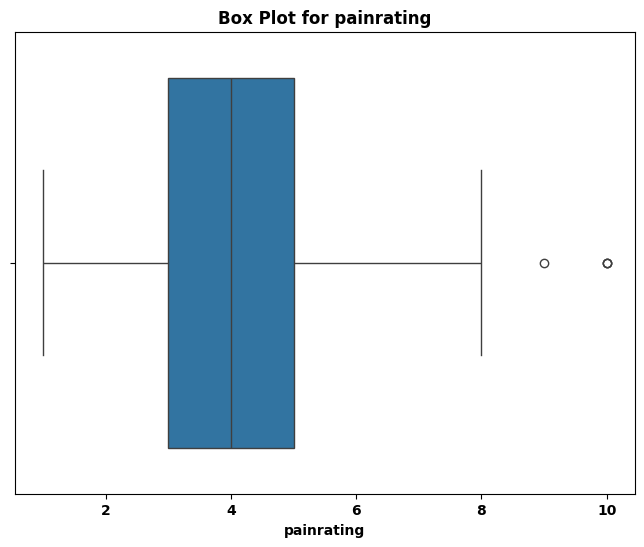

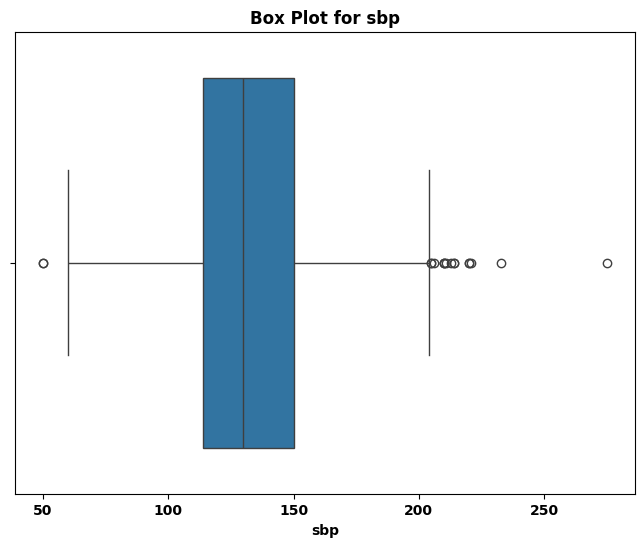

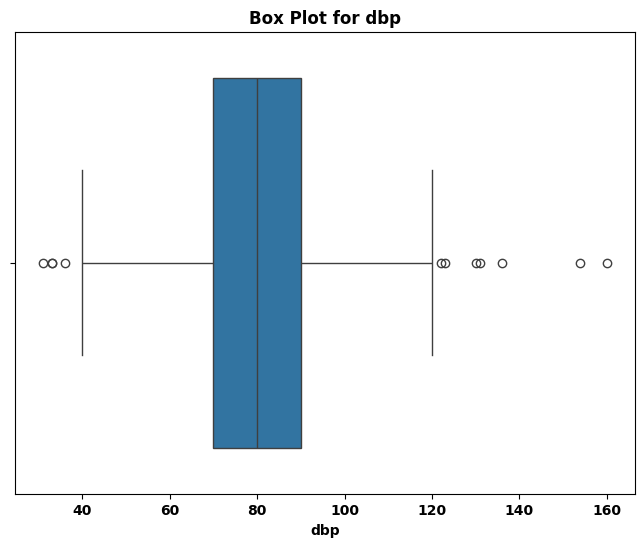

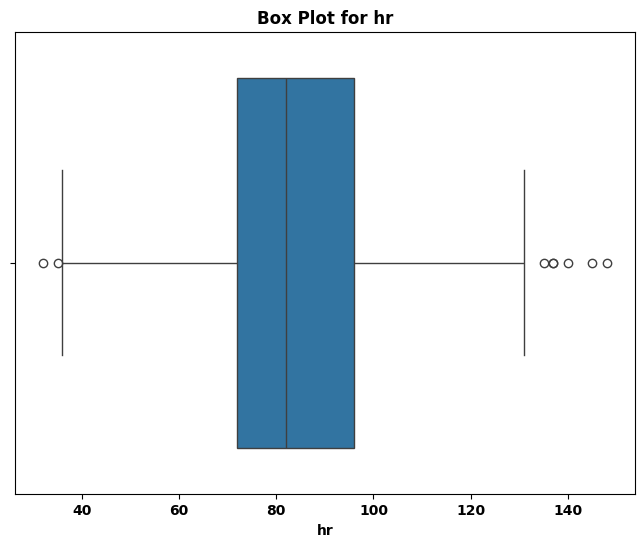

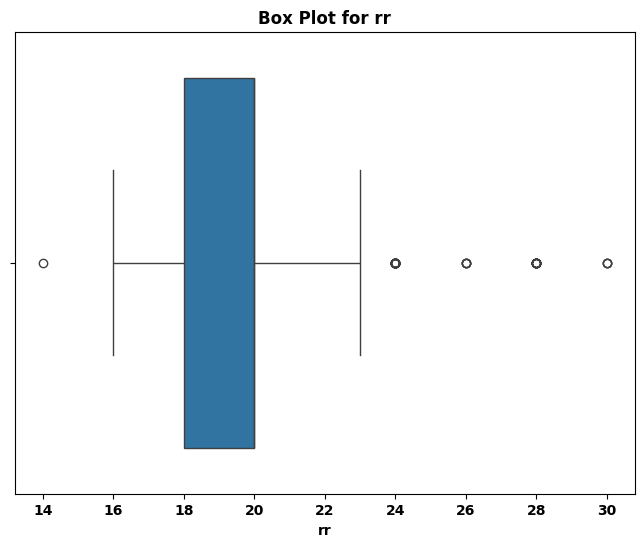

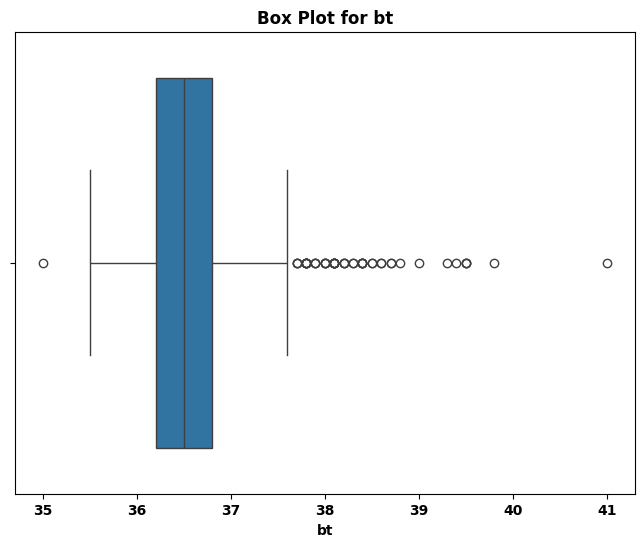

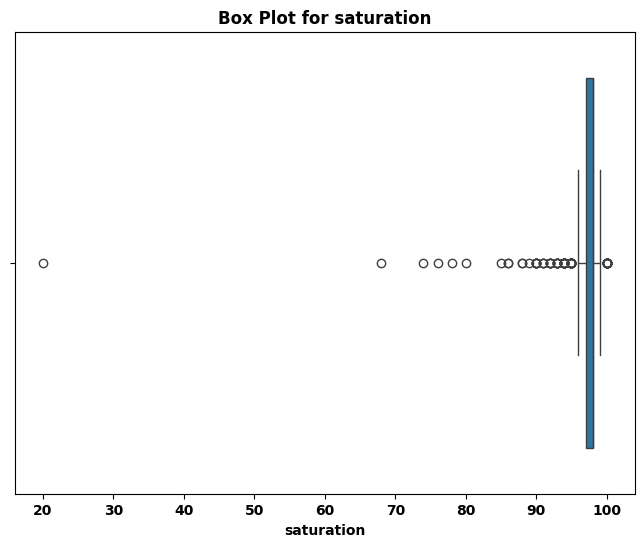

In [782]:
for column in columns_to_clean:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot for {column}')
    plt.show()

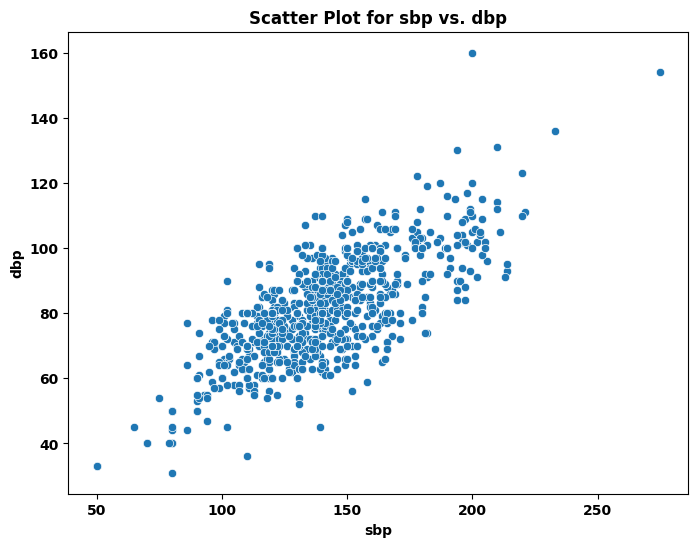

In [783]:
# Assuming 'sbp' and 'dbp' are related
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sbp', y='dbp', data=data)
plt.title('Scatter Plot for sbp vs. dbp')
plt.show()

            n_miss  ratio
saturation     697  55.01
painrating     556  43.88
dbp             29   2.29
sbp             25   1.97
rr              22   1.74
hr              20   1.58
bt              18   1.42


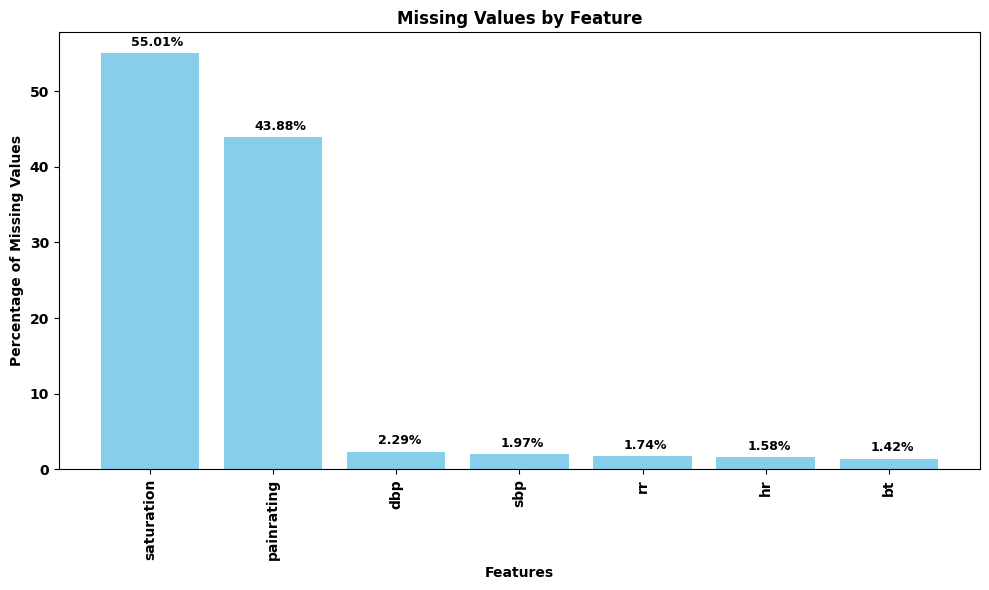

In [784]:
def missingValues(data):
    variables_NA = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[variables_NA].isnull().sum().sort_values(ascending=False)
    ratio = (data[variables_NA].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)
    missing_data = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    return missing_data

missing_data = missingValues(data)

# def columns_with_null_values(data):
#     columns_with_na = data.columns[data.isnull().any()].tolist()
#     return columns_with_na
# columns_with_null = columns_with_null_values(data)
# print(columns_with_null)

print(missing_data)
    
# Create a bar plot for missing values
plt.figure(figsize=(10, 6))
bars = plt.bar(missing_data.index, missing_data['ratio'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values by Feature')
plt.xticks(rotation=90)

# Annotate the bars with 'n_miss' and 'ratio' values
for bar, n_miss, ratio in zip(bars, missing_data['n_miss'], missing_data['ratio']):
        plt.text(bar.get_x() + bar.get_width() / 2-0.15, bar.get_height() + 1, f'{ratio}%', fontsize=9, color='black')

plt.tight_layout()
plt.show()

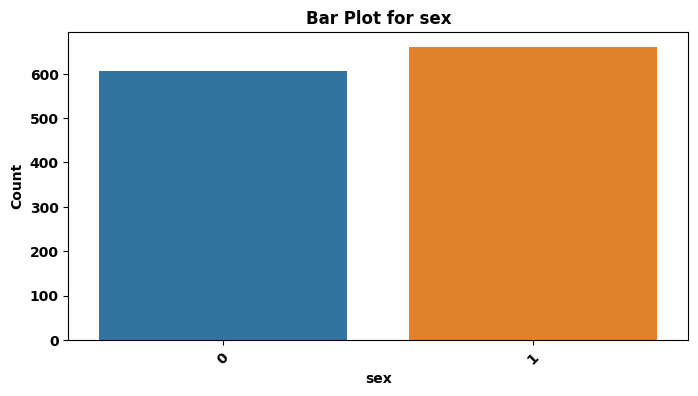

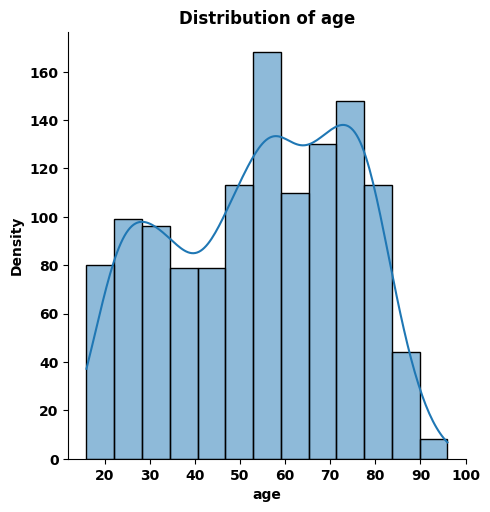

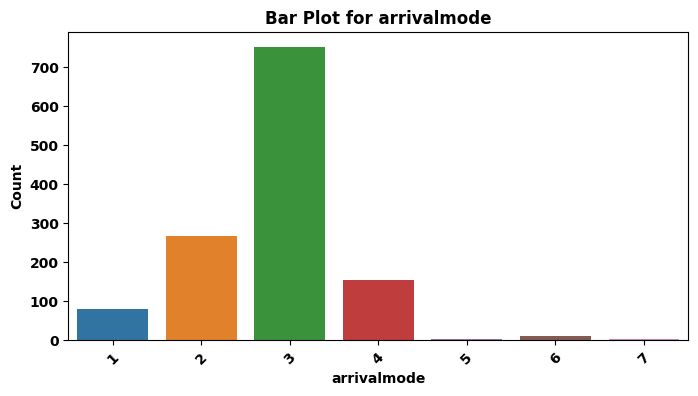

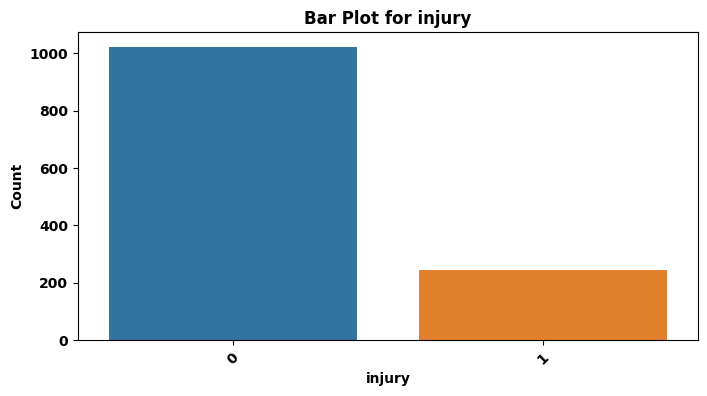

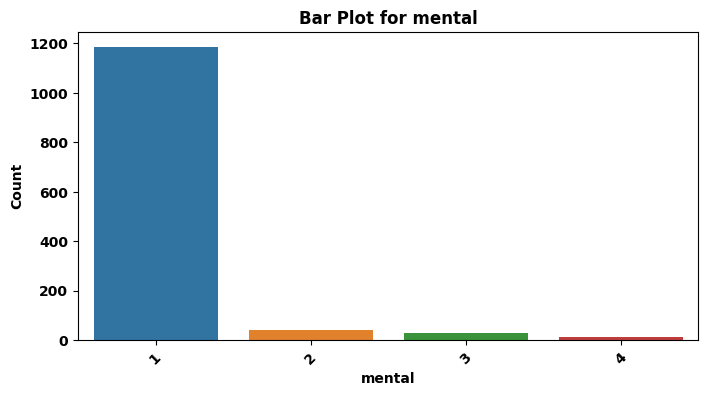

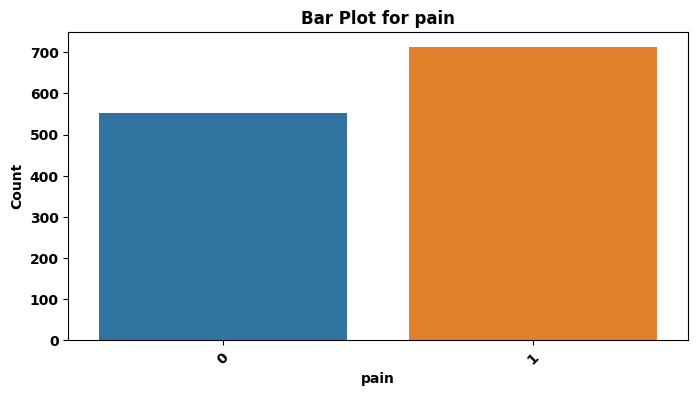

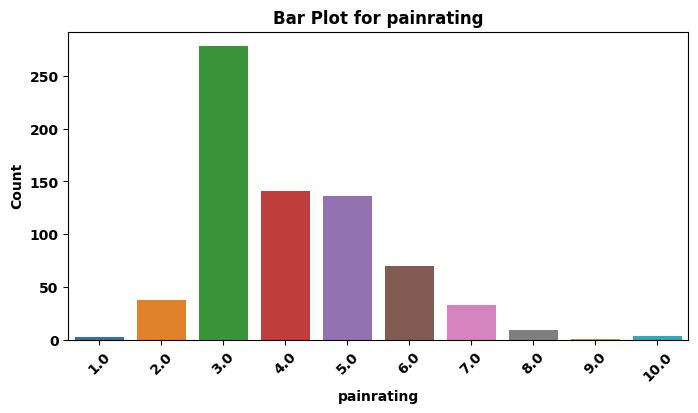

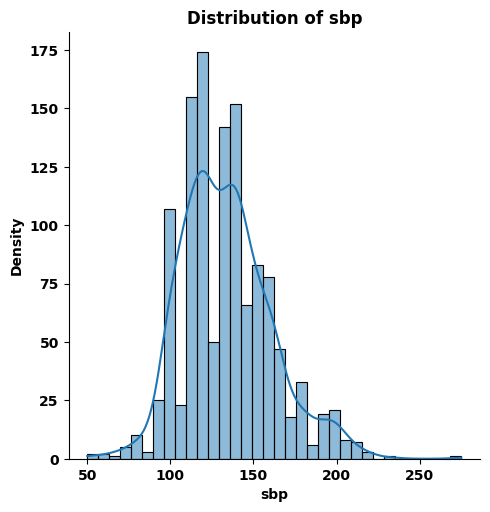

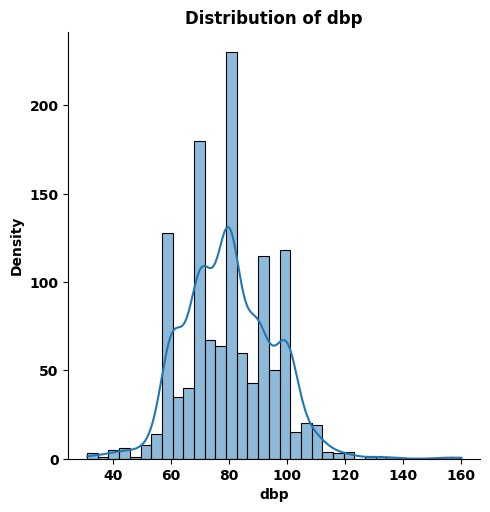

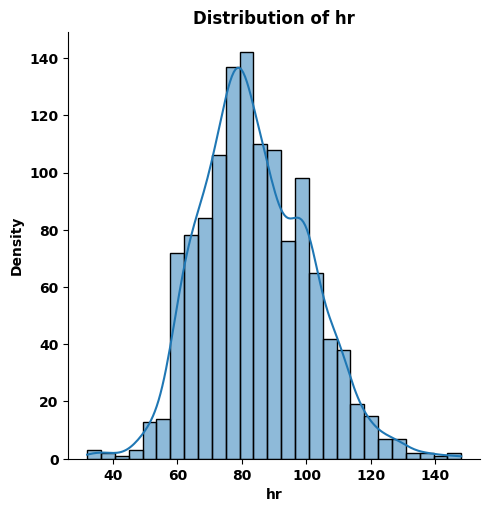

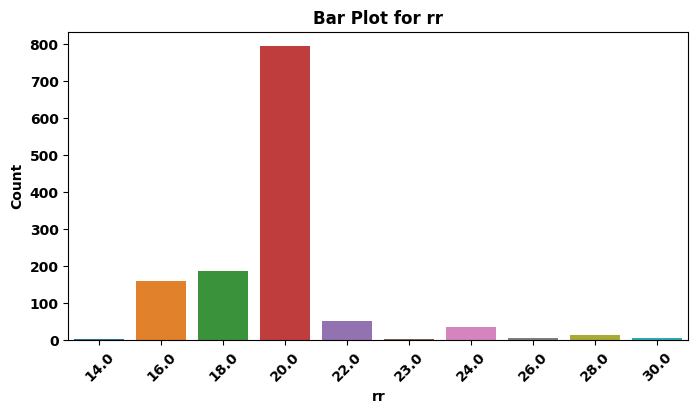

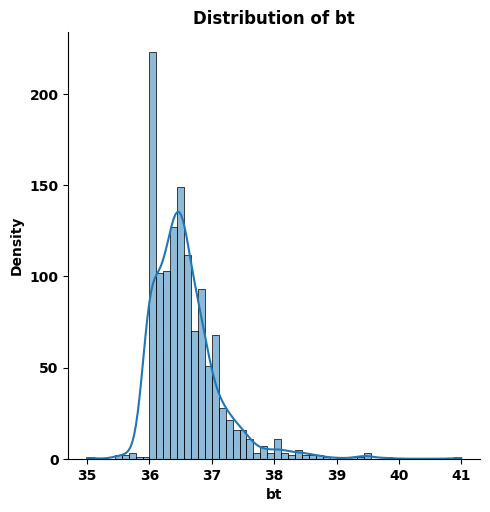

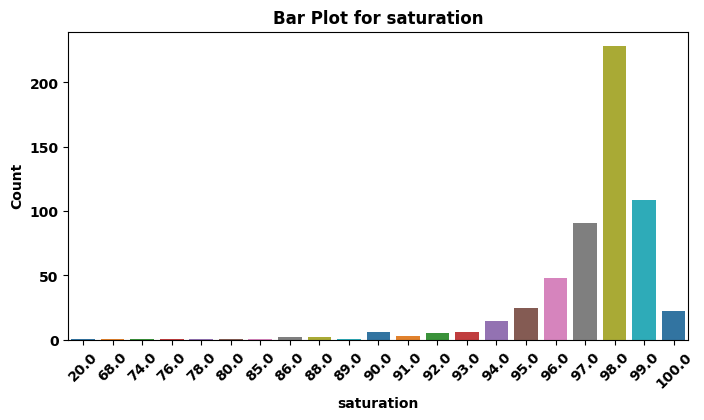

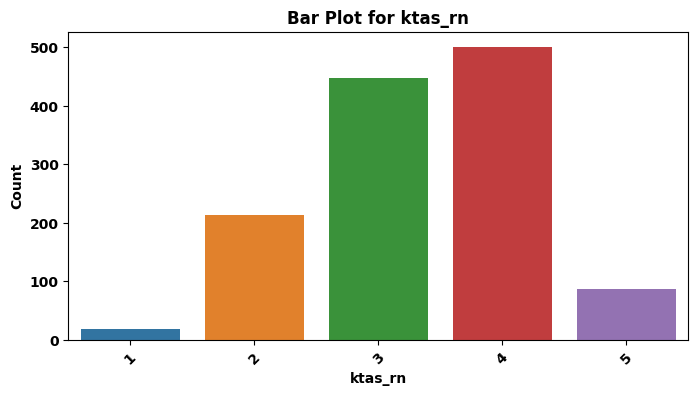

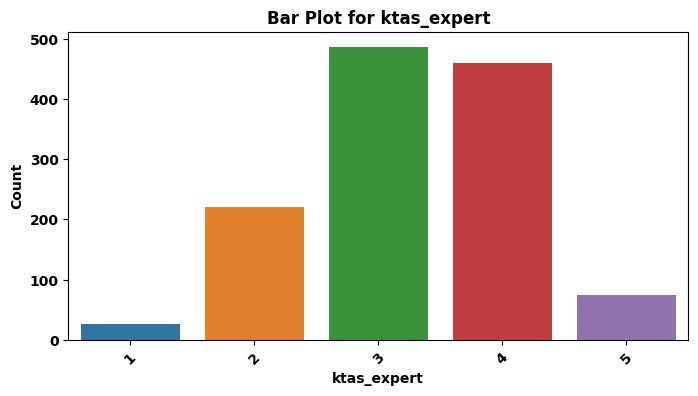

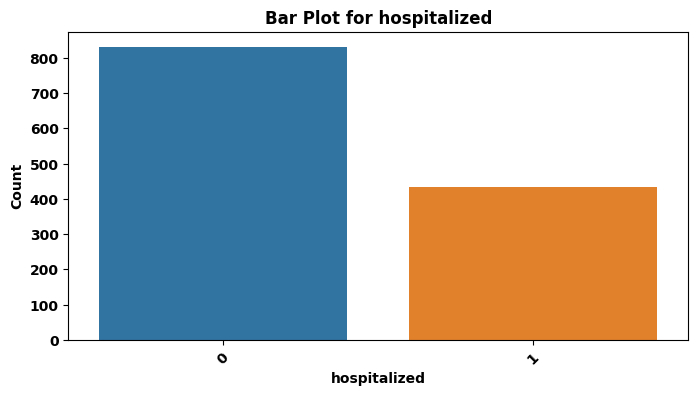

In [785]:
continuous_columns =["age", "hr","sbp","dbp","bt"]
for column in data.columns:
    if column in continuous_columns :
        sns.displot(data[column], kde=True) 
        # Additional plot customization if needed
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Density')

        # Show the plot
        plt.show()
        
    # Check if the column is non-numeric (categorical or discrete)
    elif data[column].dtype in ["object", "int64", "float64"]:
        # Count the occurrences of each unique value in the column
        value_counts = data[column].value_counts()

        # Create a bar plot
        plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
        sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette="tab10", legend=False)
        plt.title(f'Bar Plot for {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

        # Show the plot
        plt.show()

In [786]:
# # Specify the columns you want to plot
# columns_to_plot = data.columns

# # Set the number of columns per row
# columns_per_row = 2

# # Calculate the number of rows needed
# num_rows = (len(columns_to_plot) // columns_per_row) + 1

# # Create subplots
# fig, ax = plt.subplots(num_rows, columns_per_row, figsize=(15, num_rows * 3))

# # Flatten the axis array to make indexing easier
# ax = ax.flatten()

# # Loop through columns and create subplots
# for i, column in enumerate(columns_to_plot):
#     sns.countplot(x=column, data=data, ax=ax[i])
#     ax[i].set_title(f'Count Plot for {column}')
#     ax[i].set_ylabel('Count')

# # Adjust layout
# plt.tight_layout()
# plt.show()

<Axes: >

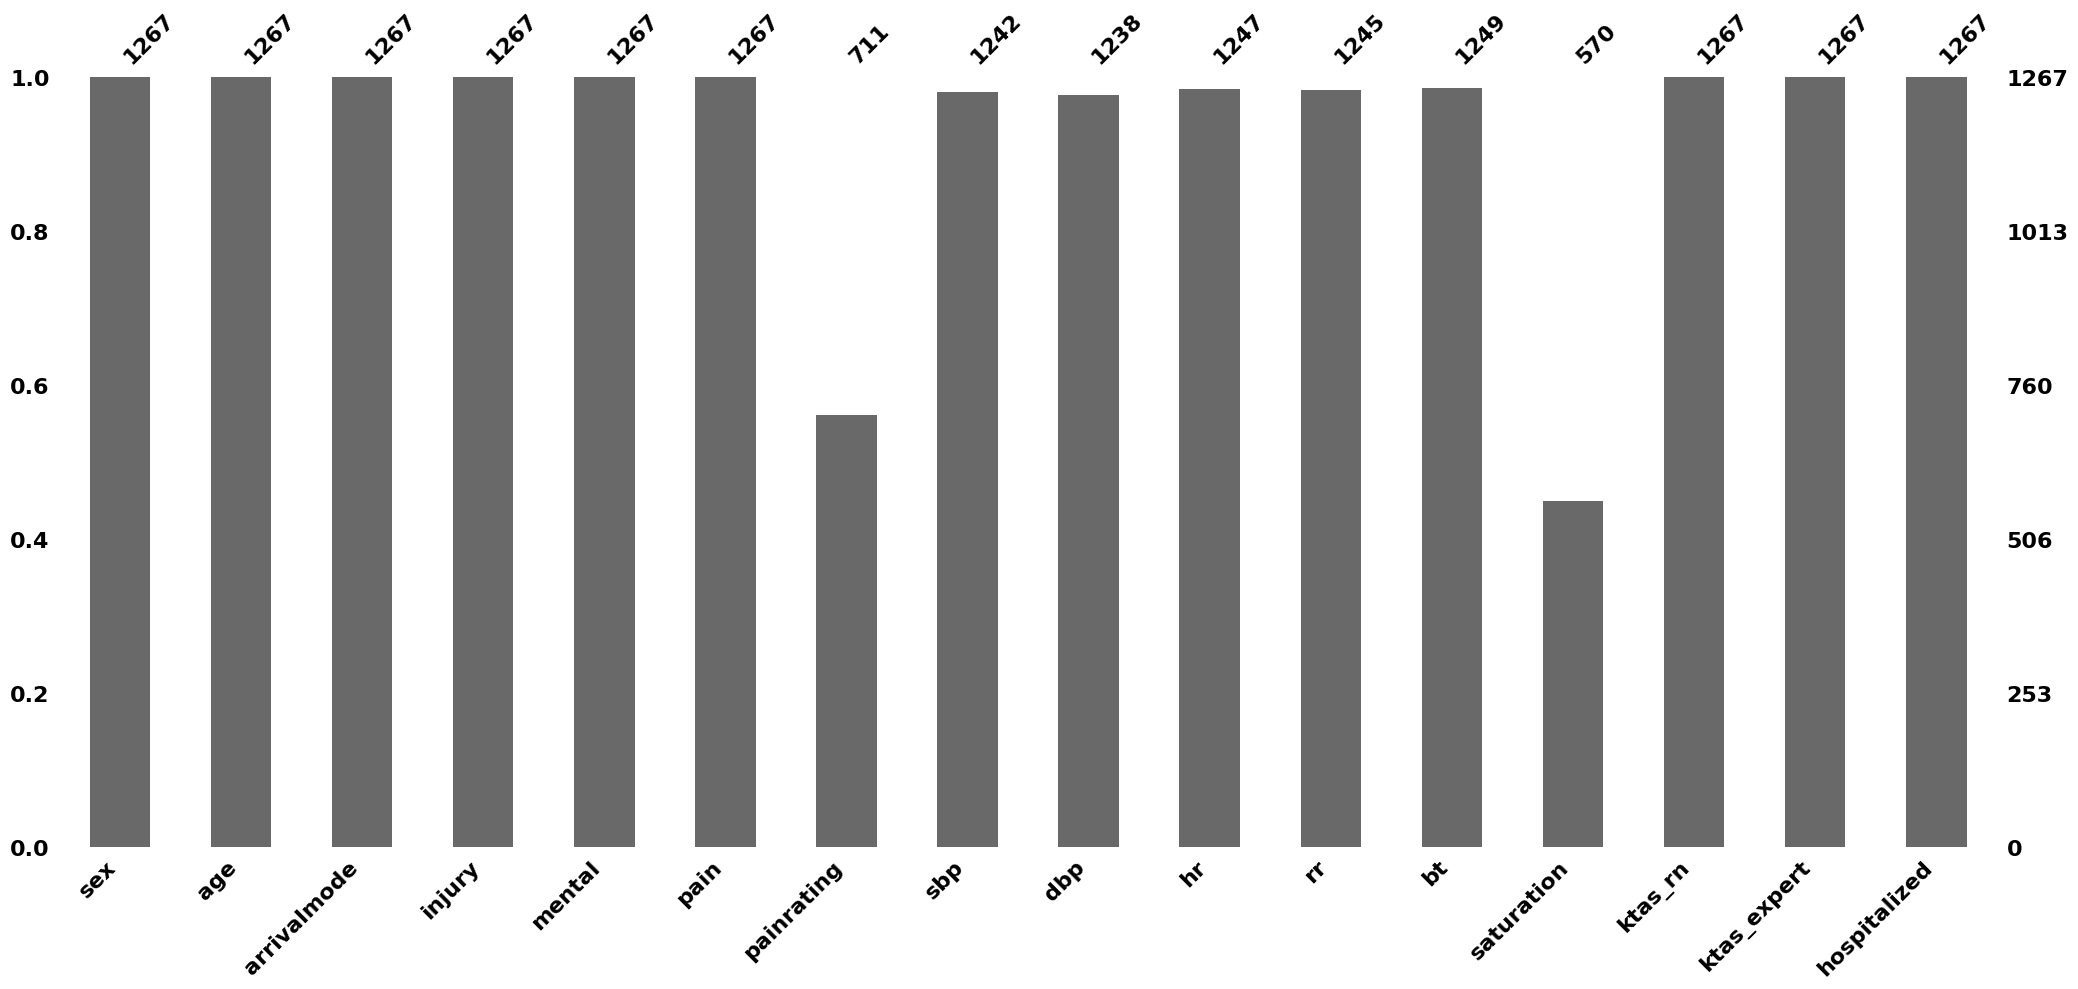

In [787]:
misno.bar(data)

In [788]:
# data.isnull().values.any()

In [789]:
# sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [790]:
# sns.boxplot(x=data['saturation'])
# plt.show()

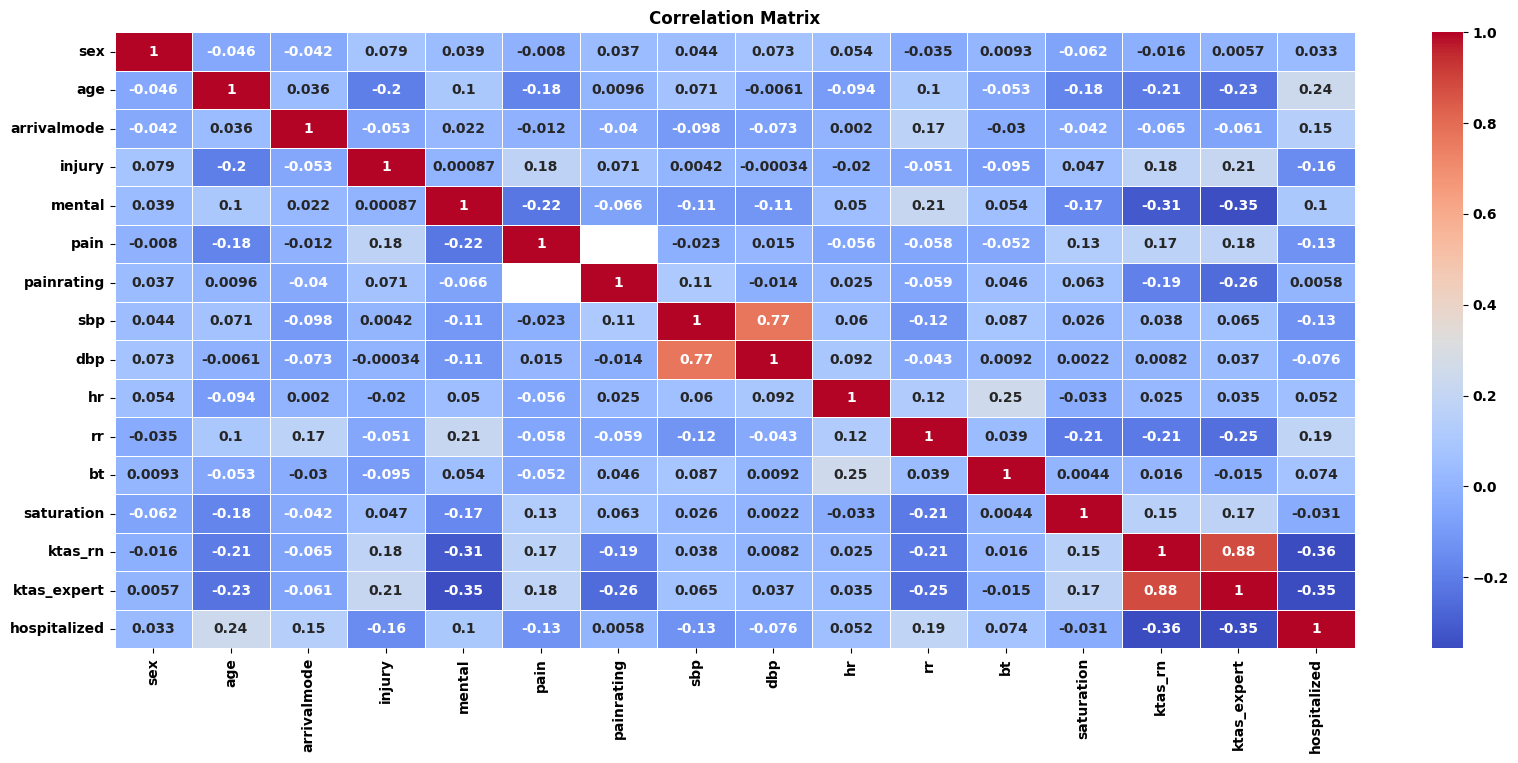

In [791]:
correlation_matrix = data.corr(method='pearson')
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

#### Handling Null values

In [792]:
def impute_nan(df,variable,method):   
    if method=="random":
        df[variable+"_random"]=df[variable]
        ##It will have the random sample to fill the na
        random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
        ##pandas need to have same index in order to merge the dataset
        random_sample.index=df[df[variable].isnull()].index
        df.loc[df[variable].isnull(),variable+'_random']=random_sample
        
    elif method=="median":
        data[variable] = data[variable].fillna(data[variable].median())
        
    elif method=="mean":
        data[variable] = data[variable].fillna(data[variable].mean())
        
        

In [793]:
# data_imputation =["painrating","rr","hr","sbp","dbp","bt"]
data_imputation =["rr","sbp","dbp","bt"]

for i in data_imputation:
    # impute_nan(data,i,"random")
    impute_nan(data,i,"median")
    
data['painrating']=data['painrating'].fillna(0)
impute_nan(data,'hr',"mean")


In [794]:
# data.drop(columns=data_imputation, inplace=True)
data.drop(columns='saturation', inplace=True)

In [795]:
# fig = plt.figure()
# ax = fig.add_subplot(111)
# data['painrating'].plot(kind='kde', ax=ax)
# # data.painrating_median.plot(kind='kde', ax=ax, color='red')
# data.painrating_random.plot(kind='kde', ax=ax, color='green')
# lines, labels = ax.get_legend_handles_labels()
# ax.legend(lines, labels, loc='best')

In [796]:
# for column in data.columns:
#     # Check if the column is non-numeric (categorical or discrete)
#     if data[column].dtype == "object" or data[column].dtype == "int64":
#         # Count the occurrences of each unique value in the column
#         value_counts = data[column].value_counts()

#         # Create a bar plot
#         plt.figure(figsize=(8, 4))  # Adjust the figure size as needed
#         sns.barplot(x=value_counts.index, y=value_counts.values)
#         plt.title(f'Bar Plot for {column}')
#         plt.xlabel(column)
#         plt.ylabel('Count')
#         plt.xticks(rotation=45)  # Rotate x-axis labels if necessary

#         # Show the plot
#         plt.show()

In [797]:
data.isnull().values.any()

False

In [798]:
# misno.bar(data)

In [799]:
count = data['hospitalized'].value_counts()
print(count)

hospitalized
0    832
1    435
Name: count, dtype: int64


#### Feature Engineering

sex
Shapiro: ShapiroResult(statistic=0.6359249353408813, pvalue=1.401298464324817e-45)
Anderson: AndersonResult(statistic=228.0137309214283, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.5217048145224941, scale=0.49972592614784533)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=nan, pvalue=1.0)
error
age
Shapiro: ShapiroResult(statistic=0.9609058499336243, pvalue=6.056940286323083e-18)
Anderson: AndersonResult(statistic=14.202624326568184, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=54.423835832675614, scale=19.725033215529816)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.9170540571212769, pvalue=8.8182982690478e-26)
S

C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).


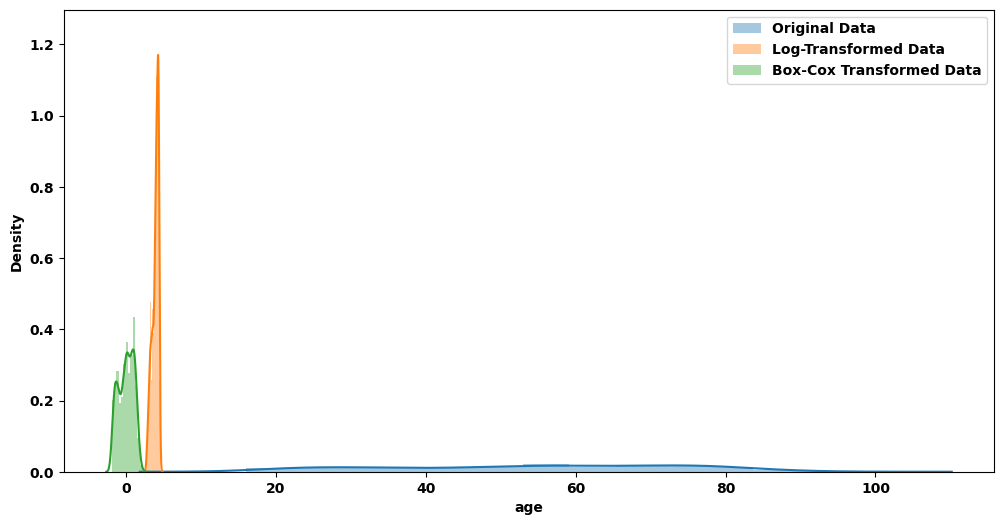

arrivalmode
Shapiro: ShapiroResult(statistic=0.8165864944458008, pvalue=1.065814715535429e-35)
Anderson: AndersonResult(statistic=109.32509427807577, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.820836621941594, scale=0.8079042344965706)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.7629884481430054, pvalue=2.8894858412285587e-39)
Shapiro Box: ShapiroResult(statistic=0.8169428706169128, pvalue=1.1325733097772974e-35)


C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_transformed_data, label='Log-T

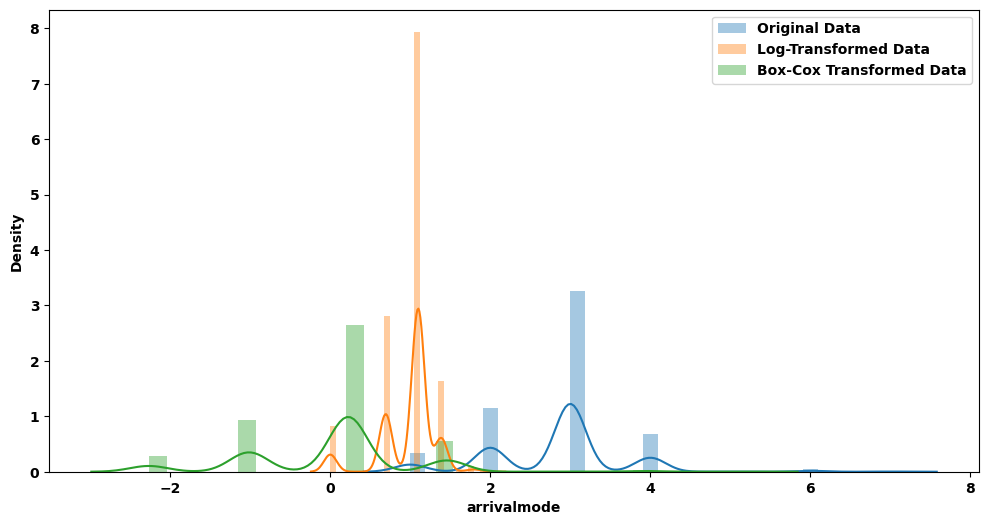

injury
Shapiro: ShapiroResult(statistic=0.4814057946205139, pvalue=0.0)
Anderson: AndersonResult(statistic=342.79512929517864, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.1925808997632202, scale=0.3944823436820904)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=nan, pvalue=1.0)
error
mental
Shapiro: ShapiroResult(statistic=0.24965578317642212, pvalue=0.0)
Anderson: AndersonResult(statistic=424.83647811281025, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=1.1057616416732439, scale=0.44776780050828396)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.2631798982620239, pvalue=0.0)
Shapiro Box: ShapiroResult(statistic=0.259686

C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\scipy\stats\_morestats.py:1871: RuntimeWarning: invalid value encountered in subtract
  x = x - np.median(x)
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn 

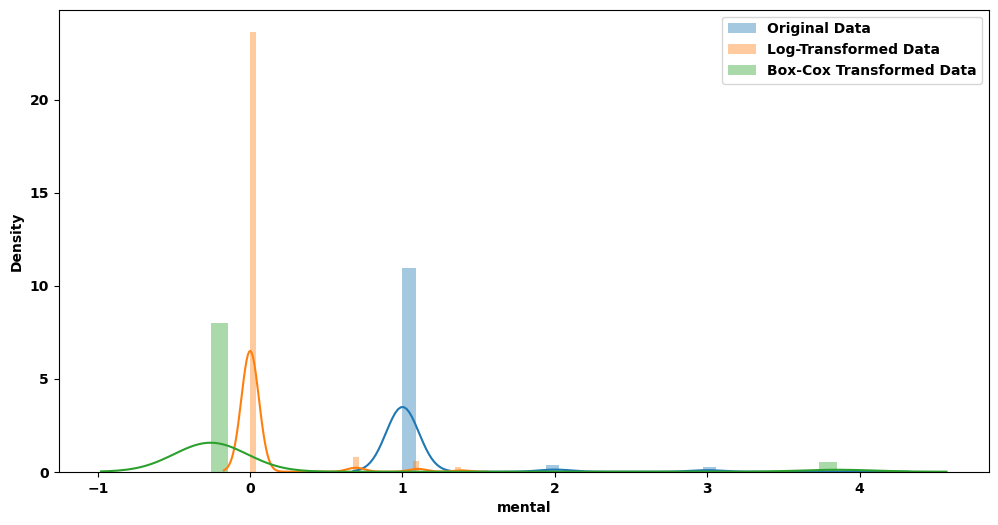

pain
Shapiro: ShapiroResult(statistic=0.6307077407836914, pvalue=1.401298464324817e-45)
Anderson: AndersonResult(statistic=232.35722932637577, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.56353591160221, scale=0.49614259205960703)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=nan, pvalue=1.0)
error
painrating
Shapiro: ShapiroResult(statistic=0.8411930203437805, pvalue=8.997572634174612e-34)
Anderson: AndersonResult(statistic=83.17920202362347, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=2.303078137332281, scale=2.2980206462114783)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=nan, pvalue=1.0)
error
sbp
Shapiro: ShapiroR

C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and wil

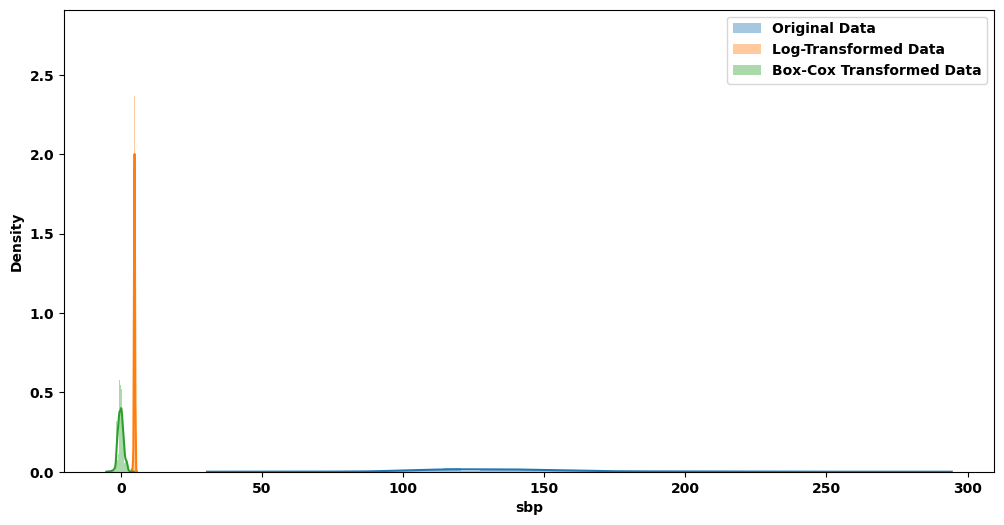

dbp
Shapiro: ShapiroResult(statistic=0.9767293930053711, pvalue=2.0101761509690175e-13)
Anderson: AndersonResult(statistic=8.667328465662877, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=79.78531965272296, scale=14.979754819734293)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.9717402458190918, pvalue=4.951349727899852e-15)
Shapiro Box: ShapiroResult(statistic=0.9813876748085022, pvalue=1.0676981868074087e-11)


C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_transformed_data, label='Log-T

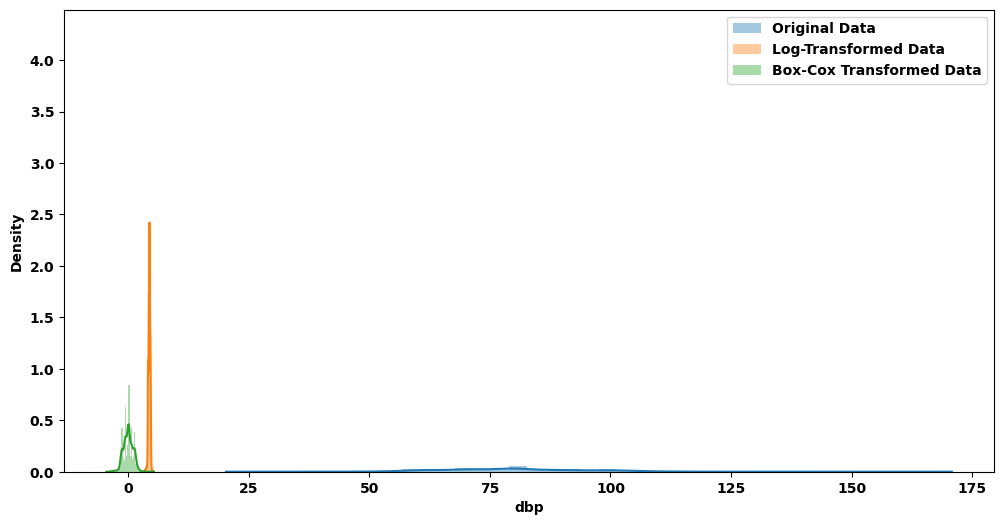

hr
Shapiro: ShapiroResult(statistic=0.9885933995246887, pvalue=2.2204240224255045e-08)
Anderson: AndersonResult(statistic=4.469312278121379, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=83.96311146752207, scale=16.51210248686504)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.9892650842666626, pvalue=5.170464945081221e-08)
Shapiro Box: ShapiroResult(statistic=0.9949921369552612, pvalue=0.00031962909270077944)


C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_transformed_data, label='Log-T

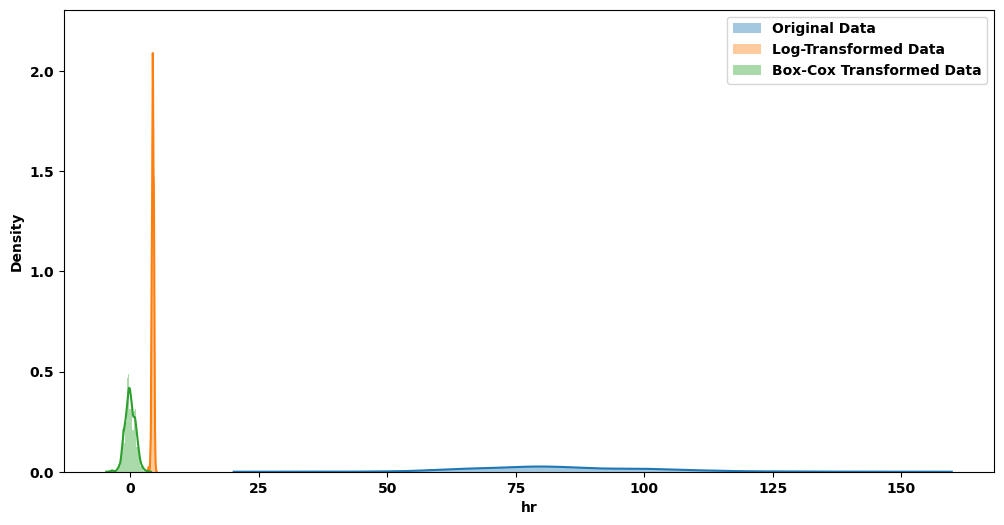

rr
Shapiro: ShapiroResult(statistic=0.7540396451950073, pvalue=8.521436091405645e-40)
Anderson: AndersonResult(statistic=135.71132200215607, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=19.515390686661405, scale=2.0000888372074974)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.7731558084487915, pvalue=1.2117822357245965e-38)
Shapiro Box: ShapiroResult(statistic=0.7746445536613464, pvalue=1.501327492733562e-38)


C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_transformed_data, label='Log-T

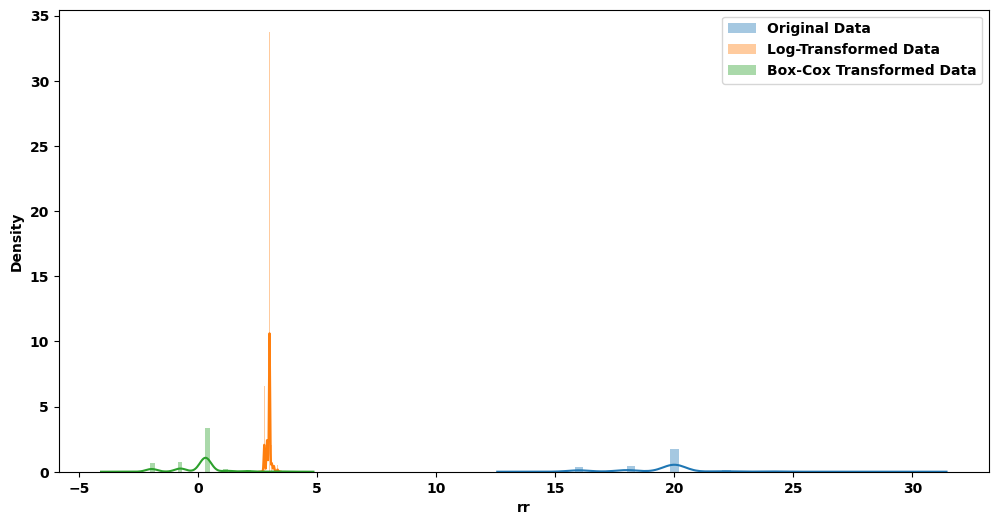

bt
Shapiro: ShapiroResult(statistic=0.8437619209289551, pvalue=1.4746621630458714e-33)
Anderson: AndersonResult(statistic=38.80341467063727, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=36.57947908445146, scale=0.5418988732044048)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.8543866872787476, pvalue=1.2219361489765591e-32)
Shapiro Box: ShapiroResult(statistic=1.0, pvalue=1.0)


C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) o

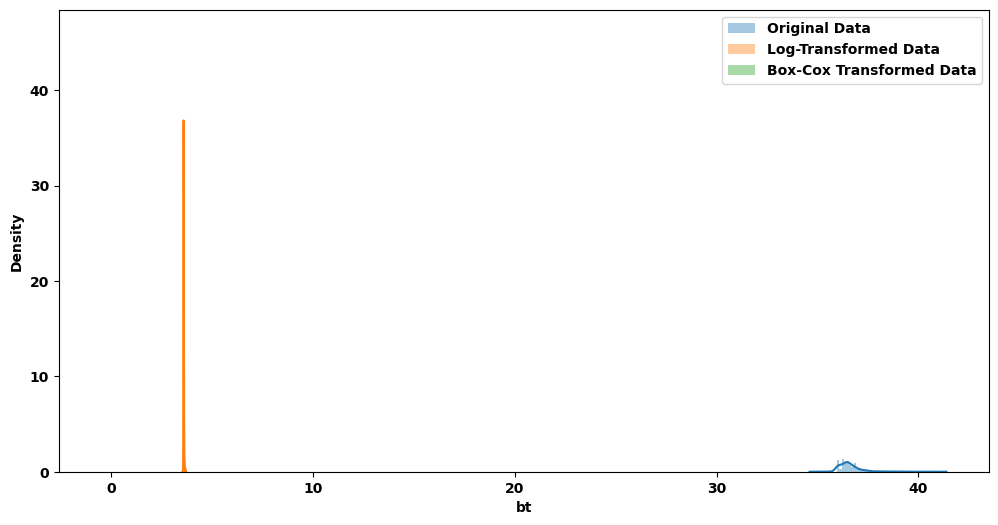

ktas_rn
Shapiro: ShapiroResult(statistic=0.8814743757247925, pvalue=4.94723555391025e-30)
Anderson: AndersonResult(statistic=70.95962723499247, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.335438042620363, scale=0.8853908339372948)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.8361825942993164, pvalue=3.495014012587144e-34)
Shapiro Box: ShapiroResult(statistic=0.8825473189353943, pvalue=6.410993469158697e-30)


C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_transformed_data, label='Log-T

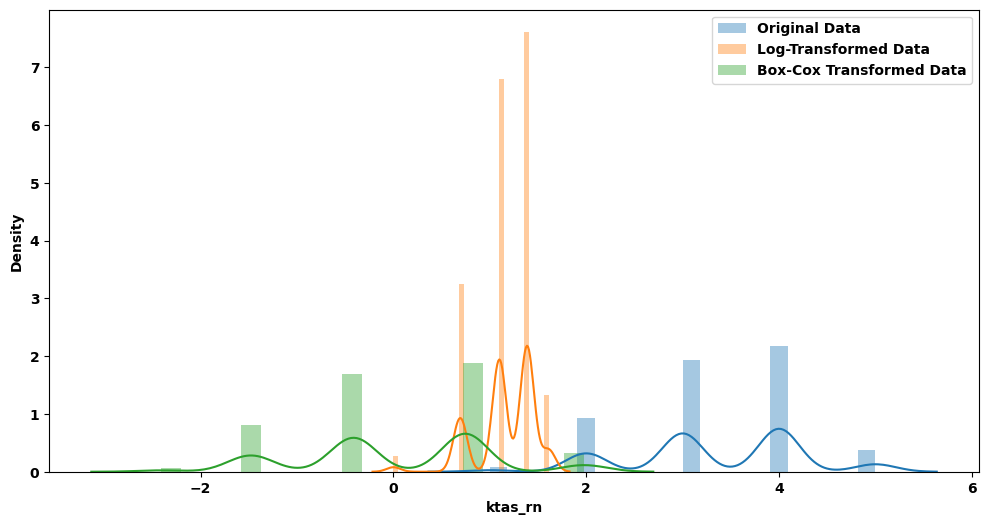

ktas_expert
Shapiro: ShapiroResult(statistic=0.8860439658164978, pvalue=1.5115507695980777e-29)
Anderson: AndersonResult(statistic=68.47008085136395, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.265982636148382, scale=0.8858033597335924)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Shapiro Log: ShapiroResult(statistic=0.8349546790122986, pvalue=2.7818544469127244e-34)
Shapiro Box: ShapiroResult(statistic=0.886867344379425, pvalue=1.8553843342305466e-29)


C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[feature], label='Original Data')
C:\Users\s-hir\AppData\Local\Temp\ipykernel_6592\772985525.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(log_transformed_data, label='Log-T

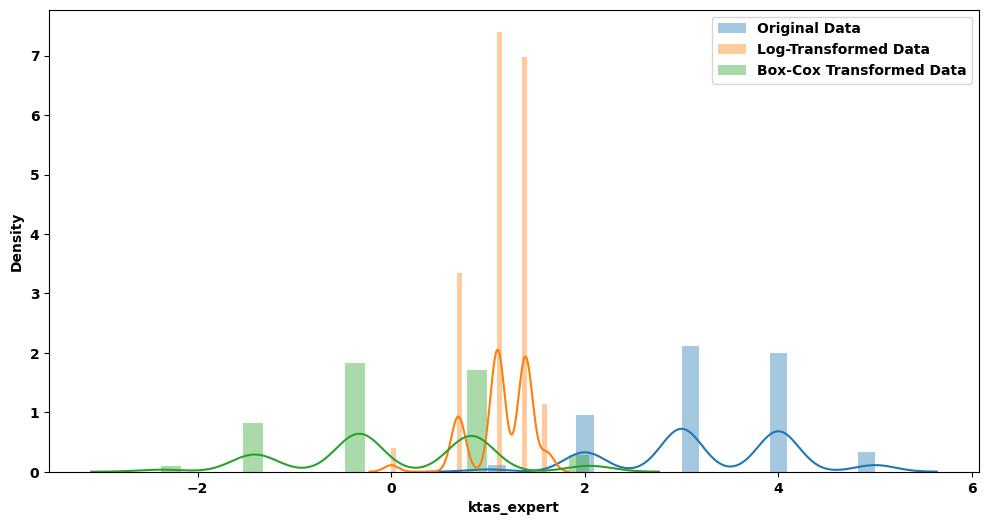

hospitalized
Shapiro: ShapiroResult(statistic=0.5998870134353638, pvalue=0.0)
Anderson: AndersonResult(statistic=257.4210264233061, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.34333070244672453, scale=0.47500822678140187)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Shapiro Log: ShapiroResult(statistic=nan, pvalue=1.0)
error


C:\Users\s-hir\anaconda3\envs\py310\lib\site-packages\scipy\stats\_morestats.py:1871: RuntimeWarning: invalid value encountered in subtract
  x = x - np.median(x)


In [803]:
def norm_test(feature):
    print(feature)
    # Original data
    print('Shapiro: {}'.format(shapiro(data[feature])))
    print('Anderson: {}'.format(anderson(data[feature])))

    # Log-transformed data
    log_transformed_data = np.log(data[feature])
    print('Shapiro Log: {}'.format(shapiro(log_transformed_data)))

    # Box-Cox transformed data
    box_cox_transformed_data = power_transform(np.array(data[feature]).reshape(-1, 1), method='box-cox')
    print('Shapiro Box: {}'.format(shapiro(box_cox_transformed_data)))

    # Plot original and transformed distributions
    plt.figure(figsize=(12, 6))
    sns.distplot(data[feature], label='Original Data')
    sns.distplot(log_transformed_data, label='Log-Transformed Data')
    sns.distplot(box_cox_transformed_data, label='Box-Cox Transformed Data')
    plt.legend()
    plt.show()

for column in data.columns:
    try:
        norm_test(column)
    except ValueError as e:
        print('error')

#### Model Training 

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X = data.drop('hospitalized', axis=1)
y = data[['hospitalized']]


smote = SMOTE(sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state = 72)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 62)



# NB = GaussianNB().fit(X_train, y_train)


# svm = SVC(random_state=357,gamma='auto').fit(X_train, y_train)






In [ ]:
# # Import necessary libraries
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# import seaborn as sns
# import matplotlib.pyplot as plt
# import re
# import string
# from imblearn.over_sampling import SMOTE
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.feature_selection import SelectKBest, chi2

# # Your code for reading the dataset remains the same.
# data = pd.read_csv("Dataset.csv")


# columns_to_drop = ['Chief_complain', 'Diagnosis in ED','Error_group', 'KTAS duration_min', 'mistriage','Group','Patients number per hour','Length of stay_min']

# data.drop(columns=columns_to_drop, inplace=True)
# data = data.rename(columns={'Disposition':'hospitalized','Arrival mode':'arrivalmode'})
# data.columns = [col.lower() for col in data.columns]
# data.head()
# columns_to_clean = ['painrating', 'sbp', 'dbp', 'hr', 'rr', 'bt', 'saturation']

# # Loop through the columns and apply cleaning and conversion
# for column in columns_to_clean:
#     data[column] = data[column].replace({'#BOŞ!': np.NaN, '??': np.NaN}).astype(float)

# # Perform one-hot encoding for categorical features
# categorical_features = ['arrivalmode', 'sex', 'injury', 'ktas_expert']
# data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# # Feature scaling for numerical features
# numerical_features = ['painrating', 'sbp', 'dbp', 'hr', 'rr', 'bt', 'saturation']
# scaler = StandardScaler()
# data[numerical_features] = scaler.fit_transform(data[numerical_features])
# data.isnull().values.any()
# misno.bar(data)

In [ ]:
# Feature selection using chi-squared test
X = data.drop('hospitalized', axis=1)
y = data['hospitalized']
selector = SelectKBest(chi2, k=10)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
data = pd.concat([data['hospitalized'], data[selected_features]], axis=1)

# Split the dataset into training and testing sets
X_resampled, y_resampled = smote.fit_resample(data.drop('hospitalized', axis=1), data['hospitalized'])
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=72)

# Hyperparameter tuning for SVM (as shown in the previous response)

# Model training and evaluation (as shown in the previous response)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
# Hyperparameter tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm = SVC(random_state=357)
svm_grid = GridSearchCV(svm, param_grid, cv=5)
svm_grid.fit(X_train, y_train)

# Get the best SVM model from the grid search
best_svm = svm_grid.best_estimator_

# Train the best SVM model
best_svm.fit(X_train, y_train)

# Make predictions
svm_predictions = best_svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, svm_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

In [ ]:

X_resampled.info()
y_resampled.info()


count = y_resampled['hospitalized'].value_counts()
print(count)

In [ ]:
NB = GaussianNB().fit(X_resampled, y_resampled)


svm = SVC(random_state=357,gamma='auto').fit(X_resampled, y_resampled)

In [ ]:
from sklearn.metrics import accuracy_score
models = [
          ("NB", NB),
          ("SVM", svm),
         ]

for name, model in models:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    msg = "%s: (%f)" % (name, acc)
    print(msg)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Make predictions on the test set
y_pred_NB = NB.predict(X_test)
y_pred_SVM = svm.predict(X_test)

# Calculate the accuracy of each model
accuracy_NB = accuracy_score(y_test, y_pred_NB)
accuracy_SVM = accuracy_score(y_test, y_pred_SVM)

# Multiply the accuracy by 100 to get the percentage accuracy
percentage_accuracy_NB = accuracy_NB * 100
percentage_accuracy_SVM = accuracy_SVM * 100

# Print the percentage accuracy of each model
print("Percentage accuracy of NB:", percentage_accuracy_NB)
print("Percentage accuracy of SVC:", percentage_accuracy_SVM)
